## Общая информация

**Срок сдачи:** 5 апреля 2022, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [25]:
import sklearn.neighbors
from sklearn.neighbors import KDTree

class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean', kf = False):
        self.k = n_neighbors
        self.X_train = None
        self.y_train = None
        self.model = None
        self.algorithm = algorithm
        self.dist = None
        self.ind = None
        self.kf = kf
        self.metric = metric
    
    def fit(self, X, y, prev_dist = None, prev_ind = None):
        if self.algorithm != "brute":
            '''self.model = sklearn.neighbors.NearestNeighbors(n_neighbors=self.k, algorithm=self.algorithm)
            self.model.fit(X)'''
        self.tree = KDTree(X, leaf_size=2) 
        self.X_train = X
        self.y_train = y
        if prev_dist is not None:
            self.ind = prev_ind
            self.dist = prev_dist

    
    
    def minkowski_dist(self, X, Y):
        # в sklearn p = 2 по умолчанию, что эквивалентно метрике "eculidean distance": 
        a = np.repeat(np.sum(X ** 2, axis=1)[:, None], np.shape(Y)[0], axis=1)
        b = np.tile(np.sum(Y ** 2, axis=1), (np.shape(X)[0], 1))
        c = 2 * (X @ Y.T)
        return np.sqrt(a+b-c)
    
    def cosine_dist(self, X, Y):
        a = X @ Y.T
        b = np.sum(X ** 2, axis=1)[:, None]
        c = np.sum(Y ** 2, axis=1)
        return 1 - a / np.sqrt(b * c)
        
    
    def find_kneighbors(self, X):
        if self.algorithm != "brute":
            dist, ind = self.tree.query(X, k=self.k)
            
        if self.metric == 'euclidean':
            distances = self.minkowski_dist(X, self.X_train)
        elif self.metric == 'cosine':
            distances = self.cosine_dist(X, self.X_train)
        
        ind = np.argsort(distances)[:, :self.k]
        dist = np.zeros((np.shape(distances)[0], self.k))
        
        for i in range(np.shape(distances)[0]):
            dist[i] = distances[i][ind[i]]

        return dist, ind

    def predict(self, X):
        if self.dist is None:
            answ = np.zeros(np.shape(X)[0])

            distances, b = self.find_kneighbors(X)
            self.dist = distances
            self.ind = b
            y = self.y_train[b]

        else:
            distances = self.dist[:,:self.k]
            b = self.ind[:,:self.k]
            y = self.y_train[b]

        def bincounter(x):
            return np.argmax(np.bincount(x))

        answ = np.apply_along_axis(bincounter, 1, y)
        if self.kf:
            return answ, self.dist, self.ind
        return answ

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [26]:
iris = datasets.load_iris()

In [27]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [28]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [29]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [30]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 2 (0.5 балла)

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [33]:
%time clf.fit(X_train, y_train)

Wall time: 999 µs


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [34]:
%time my_clf.fit(X_train, y_train)

Wall time: 1.01 ms


In [35]:
%time clf.predict(X_test)

Wall time: 3.2 ms


array([0, 0, 1, 1, 1, 2, 2, 1, 0, 0, 2, 0, 1, 2, 2])

In [36]:
%time my_clf.predict(X_test)

Wall time: 1e+03 µs


array([0, 0, 1, 1, 1, 2, 2, 1, 0, 0, 2, 0, 1, 2, 2], dtype=int64)

### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [37]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [38]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [39]:
%time clf.fit(X_train, y_train)

Wall time: 1 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [40]:
%time my_clf.fit(X_train, y_train)

Wall time: 999 µs


In [41]:
%time clf.predict(X_test)

Wall time: 5 ms


array([1, 0, 2, 0, 2, 0, 2, 1, 1, 2, 1, 1, 0, 1, 0])

In [42]:
%time my_clf.predict(X_test)

Wall time: 3 ms


array([1, 0, 2, 0, 2, 0, 2, 1, 1, 2, 1, 1, 0, 1, 0], dtype=int64)

In [43]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 4 (2.5 балла)

Рассмотрим новый датасет 20 newsgroups

In [3]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [4]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df = 0.002)

data_transformed = np.array(vectorizer.fit_transform(data).todense())

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [9]:
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=3)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [10]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


nums = list(range(15, 1, -1))

final_sc = np.zeros((3,14))
X = data_transformed
y = target
c = 0 
for train_index, test_index in kfolds.split(X):
    scores = []
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]
    for n in nums: 
        if n == 15:
            model = MyKNeighborsClassifier(n_neighbors=n, algorithm='brute', kf = True)
            print("n = ", n)
            model.fit(X_train, y_train)
            y_pred, prev_dist, prev_ind = model.predict(X_val)
            scores.append(accuracy_score(y_val, y_pred))
        else:
            model = MyKNeighborsClassifier(n_neighbors=n, algorithm='brute')
            print("n = ", n)
            model.fit(X_train, y_train, prev_dist, prev_ind)
            y_pred = model.predict(X_val)
            scores.append(accuracy_score(y_val, y_pred))
    final_sc[c] = scores
    c+=1

      

n =  15
n =  14
n =  13
n =  12
n =  11
n =  10
n =  9
n =  8
n =  7
n =  6
n =  5
n =  4
n =  3
n =  2
n =  15
n =  14
n =  13
n =  12
n =  11
n =  10
n =  9
n =  8
n =  7
n =  6
n =  5
n =  4
n =  3
n =  2
n =  15
n =  14
n =  13
n =  12
n =  11
n =  10
n =  9
n =  8
n =  7
n =  6
n =  5
n =  4
n =  3
n =  2


In [11]:
answ = np.mean(final_sc, axis = 0)

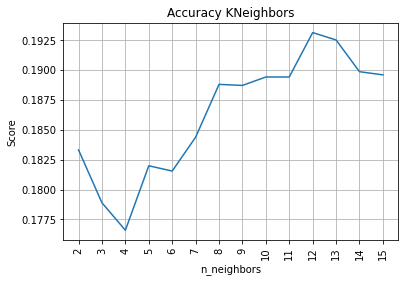

Best score with n_neighbors =  12
Best score on euclidean metric and CountVectorizer =  0.19312376202866866


In [12]:
plt.plot(nums, answ)
plt.title("Accuracy KNeighbors")
plt.xlabel("n_neighbors")
plt.ylabel("Score")
plt.grid()
plt.xticks(nums, rotation = 90)
plt.show()

print("Best score with n_neighbors = ", nums[np.argmax(answ)])
print("Best score on euclidean metric and CountVectorizer = ", max(answ))

In [13]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
np.seterr(divide='ignore', invalid='ignore')


nums = list(range(15, 1, -1))

final_sc = np.zeros((3,14))
X = data_transformed
y = target
c = 0 
for train_index, test_index in kfolds.split(X):
    scores = []
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]
    for n in nums: 
        if n == 15:
            model = MyKNeighborsClassifier(n_neighbors=n, algorithm='brute', metric='cosine', kf = True)
            print("n = ", n)
            model.fit(X_train, y_train)
            y_pred, prev_dist, prev_ind = model.predict(X_val)
            scores.append(accuracy_score(y_val, y_pred))
        else:
            model = MyKNeighborsClassifier(n_neighbors=n, algorithm='brute')
            print("n = ", n)
            model.fit(X_train, y_train, prev_dist, prev_ind)
            y_pred = model.predict(X_val)
            scores.append(accuracy_score(y_val, y_pred))
    final_sc[c] = scores
    c+=1

      

n =  15
n =  14
n =  13
n =  12
n =  11
n =  10
n =  9
n =  8
n =  7
n =  6
n =  5
n =  4
n =  3
n =  2
n =  15
n =  14
n =  13
n =  12
n =  11
n =  10
n =  9
n =  8
n =  7
n =  6
n =  5
n =  4
n =  3
n =  2
n =  15
n =  14
n =  13
n =  12
n =  11
n =  10
n =  9
n =  8
n =  7
n =  6
n =  5
n =  4
n =  3
n =  2


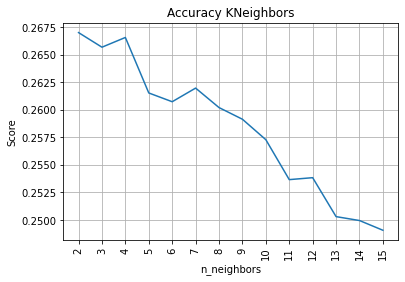

Best score with n_neighbors =  2
Best score on cosine metric and CountVectorizer =  0.26701394776737014


In [14]:
answ = np.mean(final_sc, axis = 0)
plt.plot(nums, answ)
plt.title("Accuracy KNeighbors")
plt.xlabel("n_neighbors")
plt.ylabel("Score")
plt.grid()
plt.xticks(nums, rotation = 90)
plt.show()

print("Best score with n_neighbors = ", nums[np.argmax(answ)])
print("Best score on cosine metric and CountVectorizer = ", max(answ))

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df = 0.0001)
X = np.array(vectorizer.fit_transform(data).todense())
y = target

In [62]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


nums = list(range(15, 1, -1))

final_sc = np.zeros((3,14))
c = 0 
for train_index, test_index in kfolds.split(X):
    scores = []
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]
    for n in nums: 
        if n == 15:
            model = MyKNeighborsClassifier(n_neighbors=n, algorithm='brute', kf = True)
            print("n = ", n)
            model.fit(X_train, y_train)
            y_pred, prev_dist, prev_ind = model.predict(X_val)
            scores.append(accuracy_score(y_val, y_pred))
        else:
            model = MyKNeighborsClassifier(n_neighbors=n, algorithm='brute')
            print("n = ", n)
            model.fit(X_train, y_train, prev_dist, prev_ind)
            y_pred = model.predict(X_val)
            scores.append(accuracy_score(y_val, y_pred))
    final_sc[c] = scores
    c+=1

n =  15
n =  14
n =  13
n =  12
n =  11
n =  10
n =  9
n =  8
n =  7
n =  6
n =  5
n =  4
n =  3
n =  2
n =  15
n =  14
n =  13
n =  12
n =  11
n =  10
n =  9
n =  8
n =  7
n =  6
n =  5
n =  4
n =  3
n =  2
n =  15
n =  14
n =  13
n =  12
n =  11
n =  10
n =  9
n =  8
n =  7
n =  6
n =  5
n =  4
n =  3
n =  2


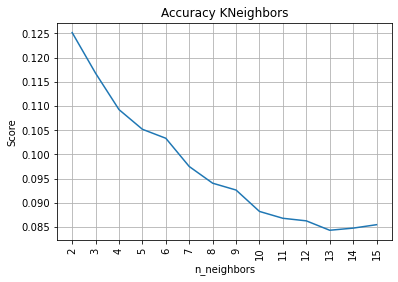

Best score with n_neighbors =  2
Best score on euclidean metric and TfidfVectorizer =  0.125154443236176


In [63]:
answ = np.mean(final_sc, axis = 0)
plt.plot(nums, answ)
plt.title("Accuracy KNeighbors")
plt.xlabel("n_neighbors")
plt.ylabel("Score")
plt.grid()
plt.xticks(nums, rotation = 90)
plt.show()

print("Best score with n_neighbors = ", nums[np.argmax(answ)])
print("Best score on euclidean metric and TfidfVectorizer = ", max(answ))

In [64]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


nums = list(range(15, 1, -1))

final_sc = np.zeros((3,14))
c = 0 
for train_index, test_index in kfolds.split(X):
    scores = []
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]
    for n in nums: 
        if n == 15:
            model = MyKNeighborsClassifier(n_neighbors=n, algorithm='brute', metric='cosine', kf = True)
            print("n = ", n)
            model.fit(X_train, y_train)
            y_pred, prev_dist, prev_ind = model.predict(X_val)
            scores.append(accuracy_score(y_val, y_pred))
        else:
            model = MyKNeighborsClassifier(n_neighbors=n, algorithm='brute')
            print("n = ", n)
            model.fit(X_train, y_train, prev_dist, prev_ind)
            y_pred = model.predict(X_val)
            scores.append(accuracy_score(y_val, y_pred))
    final_sc[c] = scores
    c+=1

n =  15
n =  14
n =  13
n =  12
n =  11
n =  10
n =  9
n =  8
n =  7
n =  6
n =  5
n =  4
n =  3
n =  2
n =  15
n =  14
n =  13
n =  12
n =  11
n =  10
n =  9
n =  8
n =  7
n =  6
n =  5
n =  4
n =  3
n =  2
n =  15
n =  14
n =  13
n =  12
n =  11
n =  10
n =  9
n =  8
n =  7
n =  6
n =  5
n =  4
n =  3
n =  2


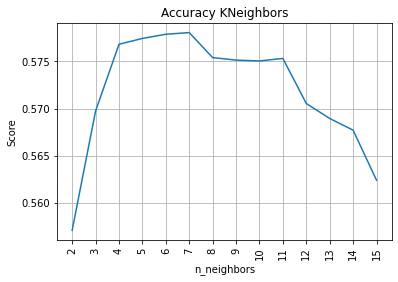

Best score with n_neighbors =  7
Best score on cosine metric and TfidfVectorizer =  0.57804493258865


In [65]:
answ = np.mean(final_sc, axis = 0)
plt.plot(nums, answ)
plt.title("Accuracy KNeighbors")
plt.xlabel("n_neighbors")
plt.ylabel("Score")
plt.grid()
plt.xticks(nums, rotation = 90)
plt.show()

print("Best score with n_neighbors = ", nums[np.argmax(answ)])
print("Best score on cosine metric and TfidfVectorizer = ", max(answ))

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

**Ответ:** Как мы видим наилучшего результата на валидации удается достичь при параметрах n_neighbors=11, metric='cosine' с представлением текста с помощью TfidfVectorizer.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [66]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])
data_test = newsgroups['data']
target_test = newsgroups['target']

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df = 0.0001)
X_train = np.array(vectorizer.fit_transform(data).todense())
X_test = np.array(vectorizer.transform(data_test).todense())
y_train = target
y_test = target_test

model = MyKNeighborsClassifier(n_neighbors=7, algorithm='brute', metric='cosine')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy on test =", accuracy_score(y_test, y_pred))

Accuracy on test = 0.5157992565055762


**Ответ:** Качество на тесте немного ниже, чем на валидации, что может быть связано с увеличением объектов для обучения и возможным небольшим переобучением из-за этого. Так же, качество на валидации зависит от разбиения выбоки на обучающую и валидационную, что так же добавляет элемент случайности в вычисление итогового качества.